In [14]:
import os
import pickle
import math
import hmmlearn.hmm as hmm
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib import cm
import librosa
import seaborn as sns
from pydub import AudioSegment, effects
import noisereduce as nr
from scipy.io.wavfile import write, read

In [15]:
class_names = ['amluongmottram','amluongnammuoi', 'baitieptheo','baitruocdo','batnhac','dunglai','meimei','phatlaplai','phatngaunhien','phattuantu','tatam','tualui','tuatoi']
states = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
dataset_path = 'dataset_final'
X = {'train': {}, 'test': {}}
y = {'train': {}, 'test': {}}
model = {}
model_path = 'trained'

In [16]:
def detect_leading_silence(sound, silence_threshold=-25.0, chunk_size=10):
        trim_ms = 0  

        assert chunk_size > 0  
        while sound[trim_ms:trim_ms + chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
            trim_ms += chunk_size

        return trim_ms

In [17]:
def get_mfcc(file_path):    
    trimmed_path = 'temp/trimmed.wav'
    sound = AudioSegment.from_file(file_path, format='wav')
    normalizedsound = effects.normalize(sound)
    normalizedsound.export(trimmed_path, format='wav')

    rate, data = read(trimmed_path)
    write(trimmed_path, rate, data)

    sound = AudioSegment.from_file(trimmed_path, format='wav')
    start_trim = detect_leading_silence(sound)
    end_trim = detect_leading_silence(sound.reverse())

    duration = len(sound)
    print(file_path)
    print(str(start_trim) + " - " + str(duration - end_trim))

    trimmed_sound = sound[start_trim:duration - end_trim]
    trimmed_sound.export(trimmed_path, format='wav')


    y, sr = librosa.load(trimmed_path)  
    hop_length = math.floor(sr * 0.010)  
    win_length = math.floor(sr * 0.025)  
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12, n_fft=1024,hop_length=hop_length, win_length=win_length)
    mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1, 1))
    delta1 = librosa.feature.delta(mfcc, order=1)
    delta2 = librosa.feature.delta(mfcc, order=2)
    X = np.concatenate([mfcc, delta1, delta2], axis=0)  
    return X.T  

In [18]:
def print_avg_mfcc(all_data, class_names):
    for cname in class_names:
        max_len = 0
        for mfcc in all_data[cname]:
            if len(mfcc) > max_len:
                max_len = len(mfcc)
        all_padded_mfcc = []
        for mfcc in all_data[cname]:
            padded_mfcc = np.pad(mfcc, ((0, max_len - len(mfcc)), (0, 0)), mode='constant')
            all_padded_mfcc.append(padded_mfcc)
        avg_mfcc = np.mean(all_padded_mfcc, axis=0)
        fig, ax = plt.subplots()
        cax = ax.imshow(avg_mfcc.T, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
        ax.set_title(f"Average MFCC for {cname}")
        plt.show()


In [19]:
length = 0
for cn in class_names:
    length += len(os.listdir(f"{dataset_path}/{cn}"))
print('Total samples:', length)

all_data = {}
all_labels = {}
for cname in class_names:
    file_paths = [os.path.join(dataset_path, cname, i) for i in os.listdir(
        os.path.join(dataset_path, cname)) if i.endswith('.wav')]
    data = [get_mfcc(file_path) for file_path in file_paths]
    all_data[cname] = data
    all_labels[cname] = [class_names.index(cname) for _ in range(len(file_paths))]


Total samples: 482
dataset_final\amluongmottram\amluongmottram1.wav
380 - 1430
dataset_final\amluongmottram\amluongmottram10.wav
290 - 1490
dataset_final\amluongmottram\amluongmottram11.wav
10 - 1500
dataset_final\amluongmottram\amluongmottram12.wav
30 - 1320
dataset_final\amluongmottram\amluongmottram13.wav
300 - 1500
dataset_final\amluongmottram\amluongmottram14.wav
100 - 1410
dataset_final\amluongmottram\amluongmottram15.wav
0 - 1500
dataset_final\amluongmottram\amluongmottram16.wav
330 - 1490
dataset_final\amluongmottram\amluongmottram17.wav
0 - 1500
dataset_final\amluongmottram\amluongmottram18.wav
0 - 1500
dataset_final\amluongmottram\amluongmottram19.wav
0 - 1500
dataset_final\amluongmottram\amluongmottram2.wav
450 - 1200
dataset_final\amluongmottram\amluongmottram20.wav
0 - 1500
dataset_final\amluongmottram\amluongmottram21.wav
0 - 1500
dataset_final\amluongmottram\amluongmottram22.wav
0 - 1500
dataset_final\amluongmottram\amluongmottram23.wav
0 - 1500
dataset_final\amluongmott

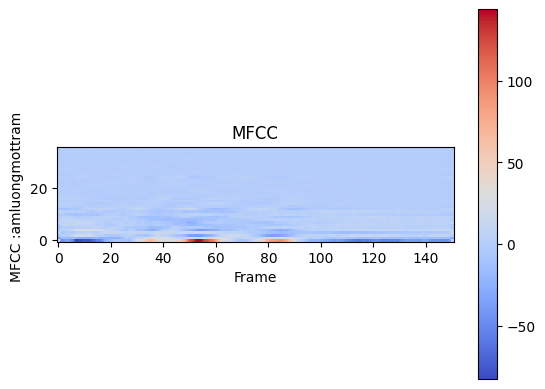

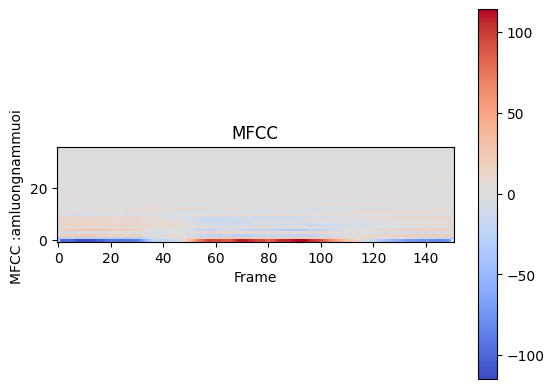

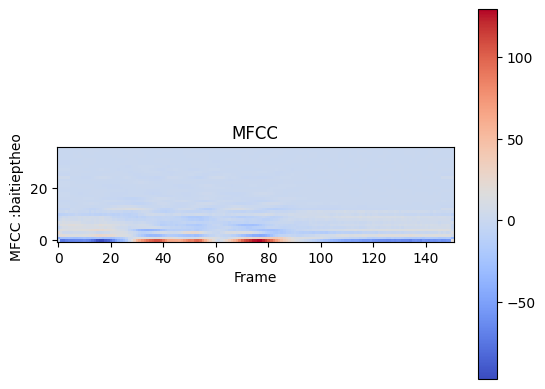

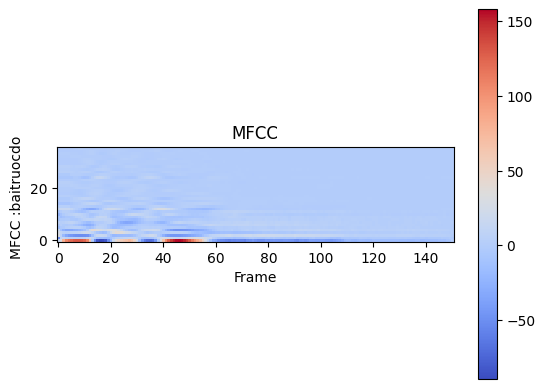

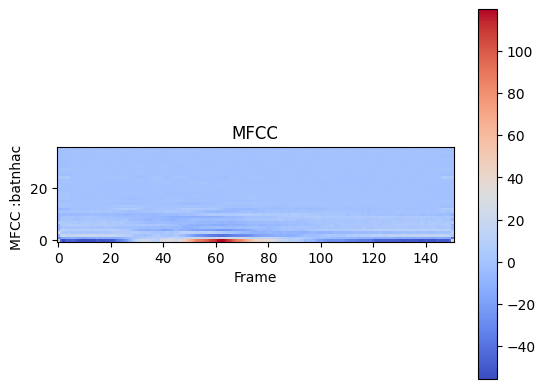

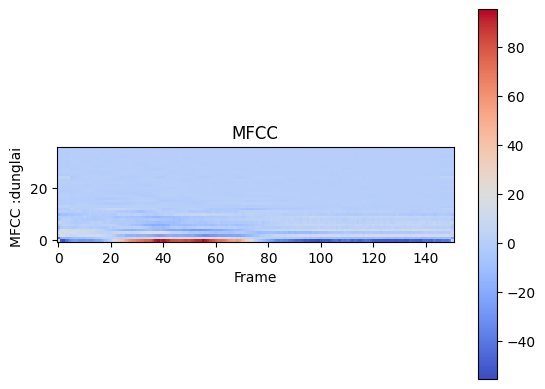

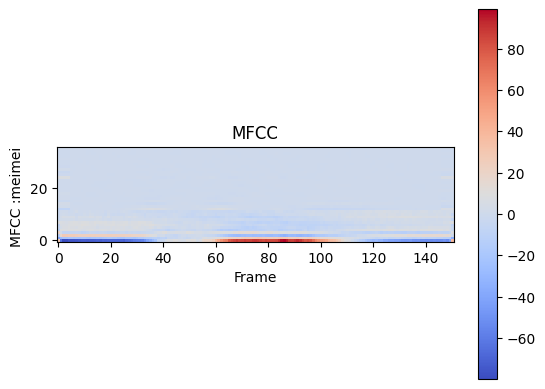

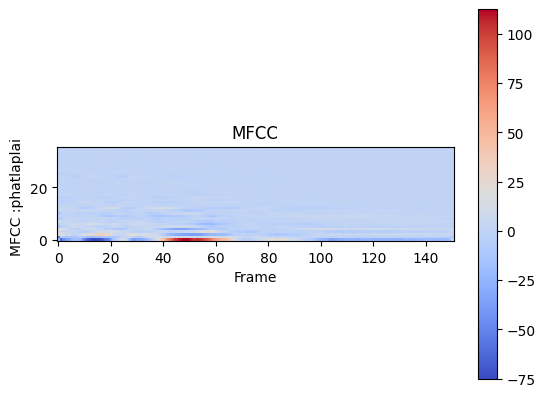

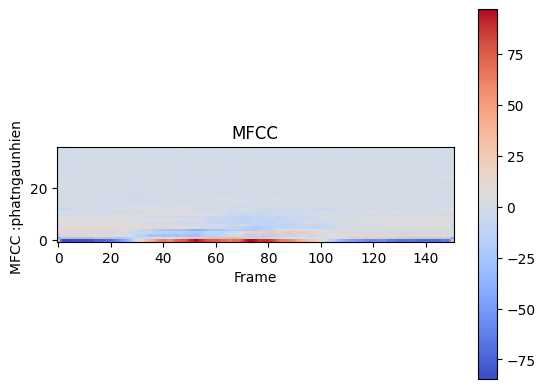

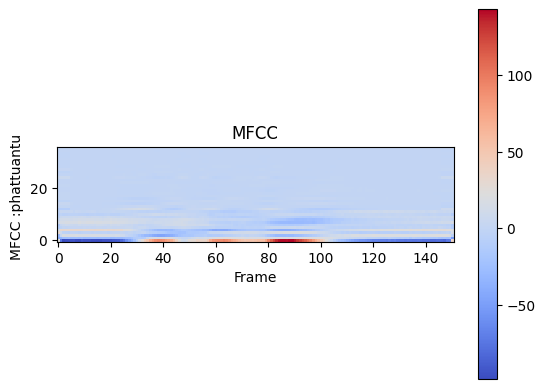

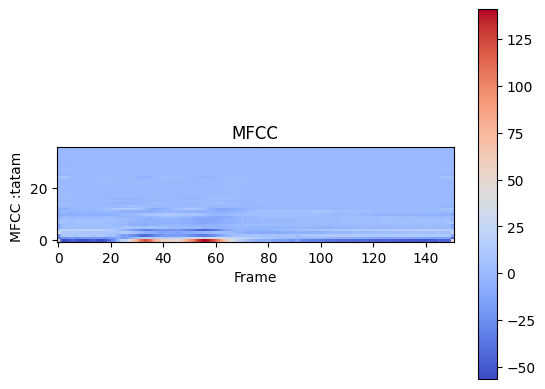

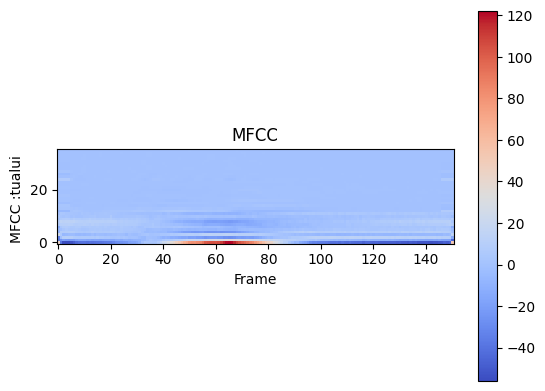

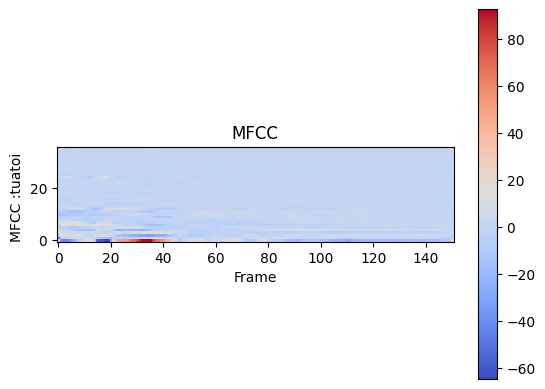

In [28]:
avg_mfcc = {}
for cname in all_data.keys():
    data = all_data[cname]
    padded_mfcc = np.zeros((len(data), max([d.shape[0] for d in data]), 36))
    for i in range(len(data)):
        mfcc = data[i]
        padded_mfcc[i, :mfcc.shape[0], :] = mfcc
    avg_mfcc[cname] = np.mean(padded_mfcc, axis=0)
for cname in class_names:
    #print(f'Label: {cname} Average MFCC: {avg_mfcc[cname]}' )
    plt.imshow(avg_mfcc[cname].T, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
    plt.title('MFCC')
    plt.xlabel('Frame')
    plt.ylabel(f'MFCC :{cname} ')
    plt.colorbar()
    plt.show()

amluongmottram train: 19 | test: 9
amluongnammuoi train: 30 | test: 14
baitieptheo train: 20 | test: 9
baitruocdo train: 25 | test: 11
batnhac train: 31 | test: 14
dunglai train: 23 | test: 10
meimei train: 23 | test: 10
phatlaplai train: 31 | test: 14
phatngaunhien train: 29 | test: 13
phattuantu train: 23 | test: 11
tatam train: 30 | test: 13
tualui train: 25 | test: 11
tuatoi train: 23 | test: 11
train samples: 332
test samples 150
amluongmottram
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         1 -251667.14936249             +nan
         2 -235633.66146179  +16033.48790070
         3 -231883.97808740   +3749.68337439
         4 -230280.22763016   +1603.75045724
         5 -229855.15347533    +425.07415483
         6 -229536.38856310    +318.76491223
         7 -229378.36007250    +158.02849060
         8 -229296.13765001     +82.22242249
         9 -229258.85743757     +37.28021244
        10 -229236.00859185     +22.84884572
        11 -229220.21312789     +15.79546395
        12 -229212.14427768      +8.06885022
        13 -229203.13916813      +9.00510955
        14 -229191.30702743     +11.83214070
        15 -229183.44590447      +7.86112296
        16 -229181.12669466      +2.31920981
        17 -229180.49094440      +0.63575026
        18 -229180.19090710      +0.30003730
        19 -229179.97648160      +0.21442551
        20 -229179.80356093      +0.17292066
        21 -229179.65886882      +0.14469212
        22 -229179.53500639      +0.12386242
        23

amluongnammuoi
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         1 -424709.81300712             +nan
         2 -397871.04308108  +26838.76992603
         3 -395730.39899226   +2140.64408883
         4 -394122.06699521   +1608.33199705
         5 -393424.86656646    +697.20042876
         6 -393081.19699711    +343.66956935
         7 -392691.91377812    +389.28321899
         8 -392312.74751150    +379.16626662
         9 -392135.18819078    +177.55932072
        10 -392044.30788977     +90.88030102
        11 -391987.62432225     +56.68356751
        12 -391955.73556730     +31.88875495
        13 -391941.74063245     +13.99493485
        14 -391933.88106682      +7.85956563
        15 -391928.11552951      +5.76553732
        16 -391923.76214855      +4.35338096
        17 -391920.70191432      +3.06023422
        18 -391918.73705937      +1.96485495
        19 -391917.60411218      +1.13294719
        20 -391917.02590553      +0.57820665
        21 -391916.76353956      +0.26236597
        22 -391916.65507165      +0.10846790
        23

baitieptheo
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         5 -250837.39752944   +1333.92913216
         6 -250275.58743377    +561.81009567
         7 -249988.13733771    +287.45009606
         8 -249817.27898129    +170.85835642
         9 -249669.86156552    +147.41741577
        10 -249572.82371267     +97.03785285
        11 -249521.34754334     +51.47616932
        12 -249493.01210217     +28.33544118
        13 -249472.90414102     +20.10796115
        14 -249453.83477283     +19.06936819
        15 -249430.85530838     +22.97946445
        16 -249402.79892564     +28.05638274
        17 -249336.29702561     +66.50190003
        18 -249011.95816911    +324.33885650
        19 -248967.48046704     +44.47770207
        20 -248958.13533612      +9.34513092
        21 -248952.18601894      +5.94931718
        22 -248946.47931825      +5.70670069
        23 -248941.32711950      +5.15219874
        24 -248938.11981703      +3.20730248
        25 -248936.33390836      +1.78590866
        26 -248935.26172561      +1.07218276
        27

baitruocdo
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         1 -258567.91731987             +nan
         2 -246038.23901604  +12529.67830383
         3 -244227.35684396   +1810.88217208
         4 -243454.03689632    +773.31994764
         5 -242852.80292476    +601.23397156
         6 -242031.36096708    +821.44195768
         7 -241516.62560861    +514.73535846
         8 -241434.03804210     +82.58756651
         9 -241407.93254046     +26.10550164
        10 -241399.75241022      +8.18013024
        11 -241397.58085427      +2.17155595
        12 -241396.69204993      +0.88880434
        13 -241396.17501926      +0.51703067
        14 -241395.93685424      +0.23816503
        15 -241395.86763154      +0.06922270
        16 -241395.84778048      +0.01985106
        17 -241395.84122340      +0.00655708


batnhac
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         1 -429136.89751239             +nan
         2 -387789.92648865  +41346.97102374
         3 -380667.46431636   +7122.46217229
         4 -378564.66272621   +2102.80159015
         5 -376687.70307236   +1876.95965385
         6 -376116.75667276    +570.94639960
         7 -375850.36551355    +266.39115922
         8 -375714.13659853    +136.22891501
         9 -375542.57938898    +171.55720955
        10 -375328.75191931    +213.82746966
        11 -375236.25610969     +92.49580962
        12 -375226.43180047      +9.82430923
        13 -375224.20391474      +2.22788572
        14 -375223.43404323      +0.76987151
        15 -375223.06278939      +0.37125384
        16 -375222.85495670      +0.20783269
        17 -375222.72837518      +0.12658152
        18 -375222.64476246      +0.08361272
        19 -375222.58393283      +0.06082963
        20 -375222.53457501      +0.04935781
        21 -375222.48988742      +0.04468759
        22 -375222.44515380      +0.04473362
        23

dunglai
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         1 -298534.95694180             +nan
         2 -273186.97502973  +25347.98191207
         3 -266168.58911343   +7018.38591630
         4 -264336.63961608   +1831.94949735
         5 -263691.60140611    +645.03820997
         6 -263110.11948129    +581.48192481
         7 -262617.78257281    +492.33690849
         8 -262497.79170299    +119.99086982
         9 -262456.06489363     +41.72680936
        10 -262425.55477927     +30.51011437
        11 -262399.07503881     +26.47974045
        12 -262377.46487295     +21.61016586
        13 -262362.39979294     +15.06508001
        14 -262352.18362341     +10.21616953
        15 -262345.71293800      +6.47068541
        16 -262341.12444363      +4.58849437
        17 -262337.81217784      +3.31226579
        18 -262335.08222061      +2.72995722
        19 -262332.76556278      +2.31665783
        20 -262331.45764552      +1.30791726
        21 -262330.83340726      +0.62423826
        22 -262330.59015344      +0.24325382
        23

meimei
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         8 -282779.03491262    +226.86315281
         9 -282681.06273757     +97.97217506
        10 -282614.52249125     +66.54024632
        11 -282593.17542897     +21.34706227
        12 -282586.85408773      +6.32134125
        13 -282584.18621423      +2.66787350
        14 -282582.78286182      +1.40335242
        15 -282581.68605450      +1.09680732
        16 -282580.06616709      +1.61988740
        17 -282576.45468124      +3.61148586
        18 -282571.32824170      +5.12643954
        19 -282566.85992745      +4.46831425
        20 -282563.34537265      +3.51455480
        21 -282560.58405791      +2.76131474
        22 -282559.22298056      +1.36107735
        23 -282558.50709730      +0.71588326
        24 -282557.79378585      +0.71331145
        25 -282556.92961834      +0.86416751
        26 -282556.17984384      +0.74977450
        27 -282555.69535711      +0.48448672
        28 -282555.33754461      +0.35781250
        29 -282555.08664705      +0.25089756
        30

phatlaplai
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         8 -313792.80568745    +183.57844928
         9 -313734.89176396     +57.91392350
        10 -313699.17552413     +35.71623983
        11 -313690.70007476      +8.47544936
        12 -313688.65847938      +2.04159539
        13 -313687.89784493      +0.76063445
        14 -313687.48554042      +0.41230451
        15 -313687.23408640      +0.25145402
        16 -313687.07334128      +0.16074512
        17 -313686.96729291      +0.10604837
        18 -313686.89559031      +0.07170260
        19 -313686.84616321      +0.04942710
        20 -313686.81157737      +0.03458584
        21 -313686.78710245      +0.02447492
        22 -313686.76964161      +0.01746084
        23 -313686.75711642      +0.01252518
        24 -313686.74810211      +0.00901431
         1 -422063.27448187             +nan


phatngaunhien
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         2 -388065.14760073  +33998.12688115
         3 -381940.09007849   +6125.05752224
         4 -381407.83427689    +532.25580160
         5 -381237.01637941    +170.81789748
         6 -381176.69254092     +60.32383849
         7 -381155.66013560     +21.03240532
         8 -381144.47048896     +11.18964664
         9 -381136.80008709      +7.67040186
        10 -381131.84473905      +4.95534804
        11 -381126.62862145      +5.21611760
        12 -381115.89044263     +10.73817882
        13 -381105.42329973     +10.46714290
        14 -381100.10395304      +5.31934670
        15 -381093.72739511      +6.37655793
        16 -381087.44909806      +6.27829705
        17 -381081.75572007      +5.69337799
        18 -381076.53475838      +5.22096168
        19 -381072.77236469      +3.76239370
        20 -381070.39272880      +2.37963589
        21 -381068.62443271      +1.76829609
        22 -381066.53534181      +2.08909090
        23 -381063.08112479      +3.45421702
        24

phattuantu
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         1 -335584.96802847             +nan
         2 -311336.47407469  +24248.49395378
         3 -305189.21184625   +6147.26222844
         4 -303370.65908067   +1818.55276558
         5 -302442.78832203    +927.87075864
         6 -302253.66546146    +189.12286057
         7 -302223.19322080     +30.47224066
         8 -302215.45054562      +7.74267518
         9 -302212.04315859      +3.40738703
        10 -302210.01486593      +2.02829266
        11 -302208.78157500      +1.23329093
        12 -302208.09642367      +0.68515133
        13 -302207.73548248      +0.36094119
        14 -302207.54315384      +0.19232864
        15 -302207.43708589      +0.10606795
        16 -302207.37676446      +0.06032143
        17 -302207.34166757      +0.03509689
        18 -302207.32086489      +0.02080268
        19 -302207.30831043      +0.01255446
        20 -302207.30058592      +0.00772452
         1 -391753.82161169             +nan
         2 -370805.85548879  +20947.96612290
         3

tatam
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


        10 -352485.76211277    +438.28205649
        11 -351667.70161098    +818.06050178
        12 -350789.12686665    +878.57474434
        13 -350723.40627091     +65.72059574
        14 -350703.72700271     +19.67926820
        15 -350697.58773835      +6.13926435
        16 -350696.09111400      +1.49662435
        17 -350695.40937574      +0.68173826
        18 -350694.99632675      +0.41304899
        19 -350694.72128636      +0.27504039
        20 -350694.53095314      +0.19033322
        21 -350694.39833313      +0.13262001
        22 -350694.30695681      +0.09137632
        23 -350694.24517351      +0.06178330
        24 -350694.20422895      +0.04094456
        25 -350694.17757937      +0.02664958
        26 -350694.16048753      +0.01709184
        27 -350694.14964814      +0.01083939
        28 -350694.14282985      +0.00681828
         1 -337372.75899601             +nan
         2 -301817.88833180  +35554.87066421
         3 -293739.72972402   +8078.15860778
         4

tualui
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


        11 -287406.90758032    +237.82634640
        12 -287330.75780178     +76.14977854
        13 -287309.53950053     +21.21830125
        14 -287303.47225333      +6.06724720
        15 -287301.19746753      +2.27478580
        16 -287300.30560874      +0.89185879
        17 -287300.00601992      +0.29958883
        18 -287299.90182284      +0.10419708
        19 -287299.86237916      +0.03944368
        20 -287299.84644096      +0.01593820
        21 -287299.83961704      +0.00682392
         1 -260719.79307127             +nan
         2 -247072.98158529  +13646.81148599
         3 -244769.10440129   +2303.87718400


tuatoi
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]


         4 -243736.10258618   +1033.00181511
         5 -242633.63444536   +1102.46814081
         6 -241365.05381977   +1268.58062560
         7 -238649.69534408   +2715.35847569
         8 -236349.43941719   +2300.25592689
         9 -235733.67454979    +615.76486741
        10 -235500.79453418    +232.88001561
        11 -235407.98295209     +92.81158209
        12 -235355.02886294     +52.95408915
        13 -235330.81649346     +24.21236949
        14 -235321.89870341      +8.91779004
        15 -235318.09078377      +3.80791964
        16 -235316.05486436      +2.03591941
        17 -235314.95027084      +1.10459352
        18 -235314.37498194      +0.57528890
        19 -235314.05767350      +0.31730844
        20 -235313.86400365      +0.19366985
        21 -235313.74207906      +0.12192459
        22 -235313.66869150      +0.07338757
        23 -235313.62863030      +0.04006120
        24 -235313.60921763      +0.01941267
        25 -235313.60081453      +0.00840310


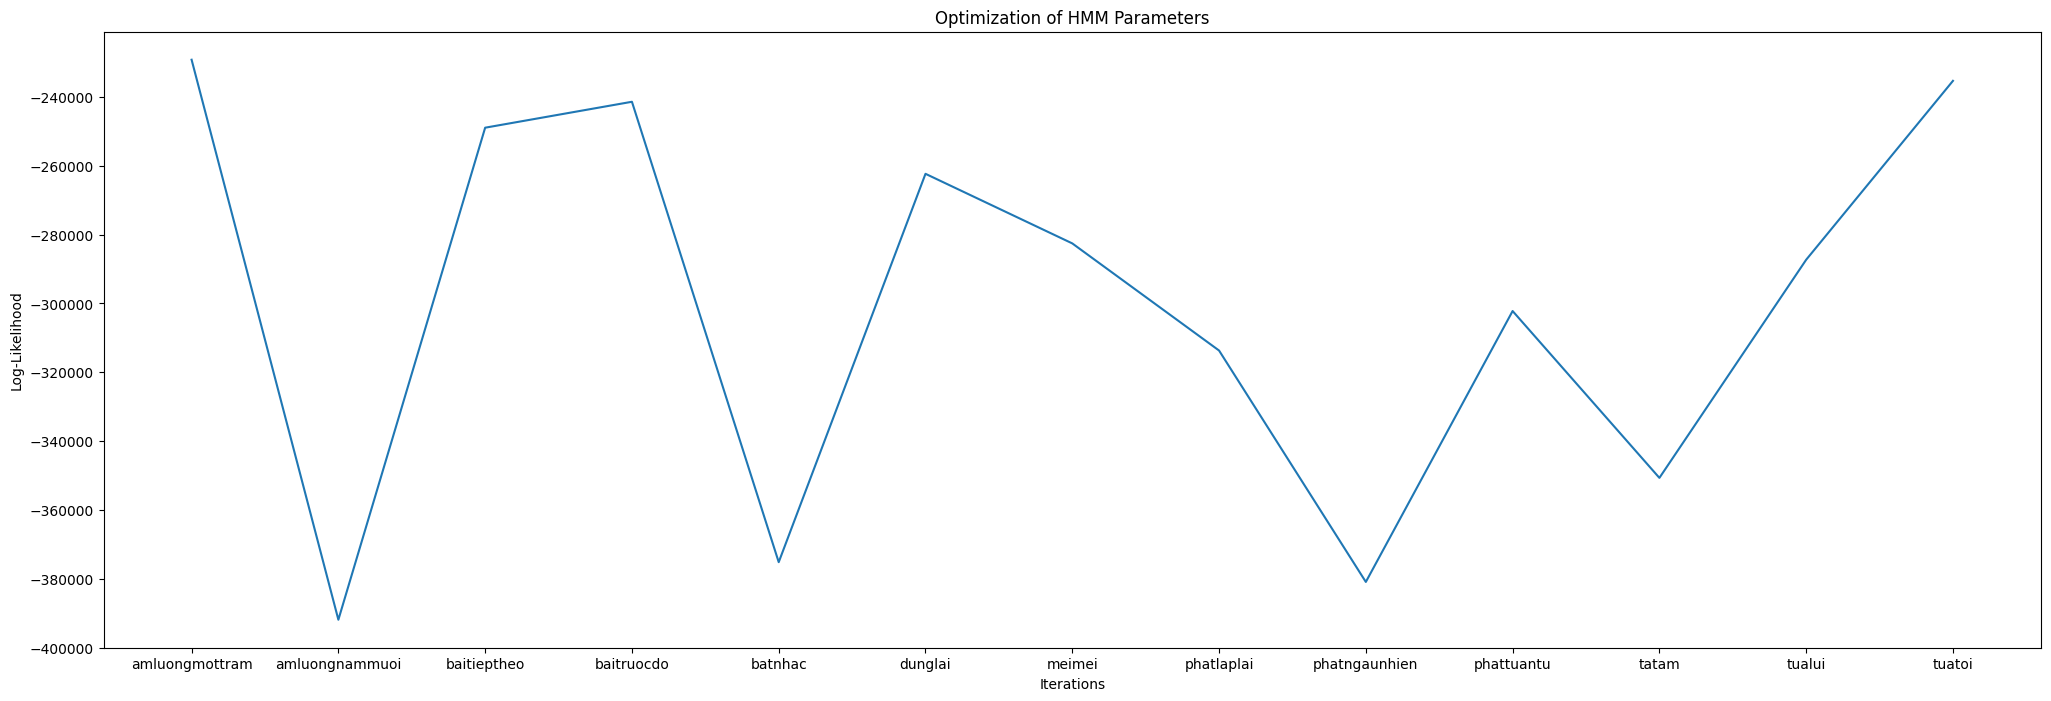

In [21]:
for cname in class_names:
    log_likelihoods = []


    x_train, x_test, y_train, y_test = train_test_split(
            all_data[cname], all_labels[cname],
            test_size=0.3,
            random_state=1
        )

    X['train'][cname] = x_train
    X['test'][cname] = x_test
    y['test'][cname] = y_test

total_train = 0
total_test = 0
for cname in class_names:
    train_count = len(X['train'][cname])
    test_count = len(X['test'][cname])
    print(cname, 'train:', train_count, '| test:', test_count)
    total_train += train_count
    total_test += test_count
print('train samples:', total_train)
print('test samples', total_test)

for idx, cname in enumerate(class_names):
    start_prob = np.full(states[idx], 0.0)
    start_prob[0] = 1.0
    trans_matrix = np.full((states[idx], states[idx]), 0.0)
    p = 0.5
    np.fill_diagonal(trans_matrix, p)
    np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
    trans_matrix[-1, -1] = 1.0

            
    print(cname)
    print(trans_matrix)

    model[cname] = hmm.GaussianHMM(
        n_components=states[idx],
        verbose=True,
        n_iter=300,
        startprob_prior=start_prob,
        transmat_prior=trans_matrix,
        params='stmc',
        init_params='stmc',
        random_state=0
    )     
    model[cname].fit(X=np.vstack(X['train'][cname]),
        lengths=[x.shape[0] for x in X['train'][cname]])
    log_likelihoods.append(model[cname].score(X=np.vstack(X['train'][cname]),
                                              lengths=[x.shape[0] for x in X['train'][cname]]))
plt.figure(figsize=(25,8))
plt.plot(range(len(class_names)), log_likelihoods)
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.xticks(range(len(class_names)), class_names)
plt.title('Optimization of HMM Parameters')
plt.show()

                        
for cname in class_names:
    name = f'{model_path}/model_{cname}.pkl'
    with open(name, 'wb') as file:
        pickle.dump(model[cname], file)

amluongmottram: 1.0
amluongnammuoi: 1.0
baitieptheo: 1.0
baitruocdo: 0.9534883720930233
batnhac: 0.9649122807017544
dunglai: 0.9701492537313433
meimei: 0.961038961038961
phatlaplai: 0.967032967032967
phatngaunhien: 0.9711538461538461
phattuantu: 0.9739130434782609
tatam: 0.9765625
tualui: 0.9640287769784173
tuatoi: 0.9666666666666667


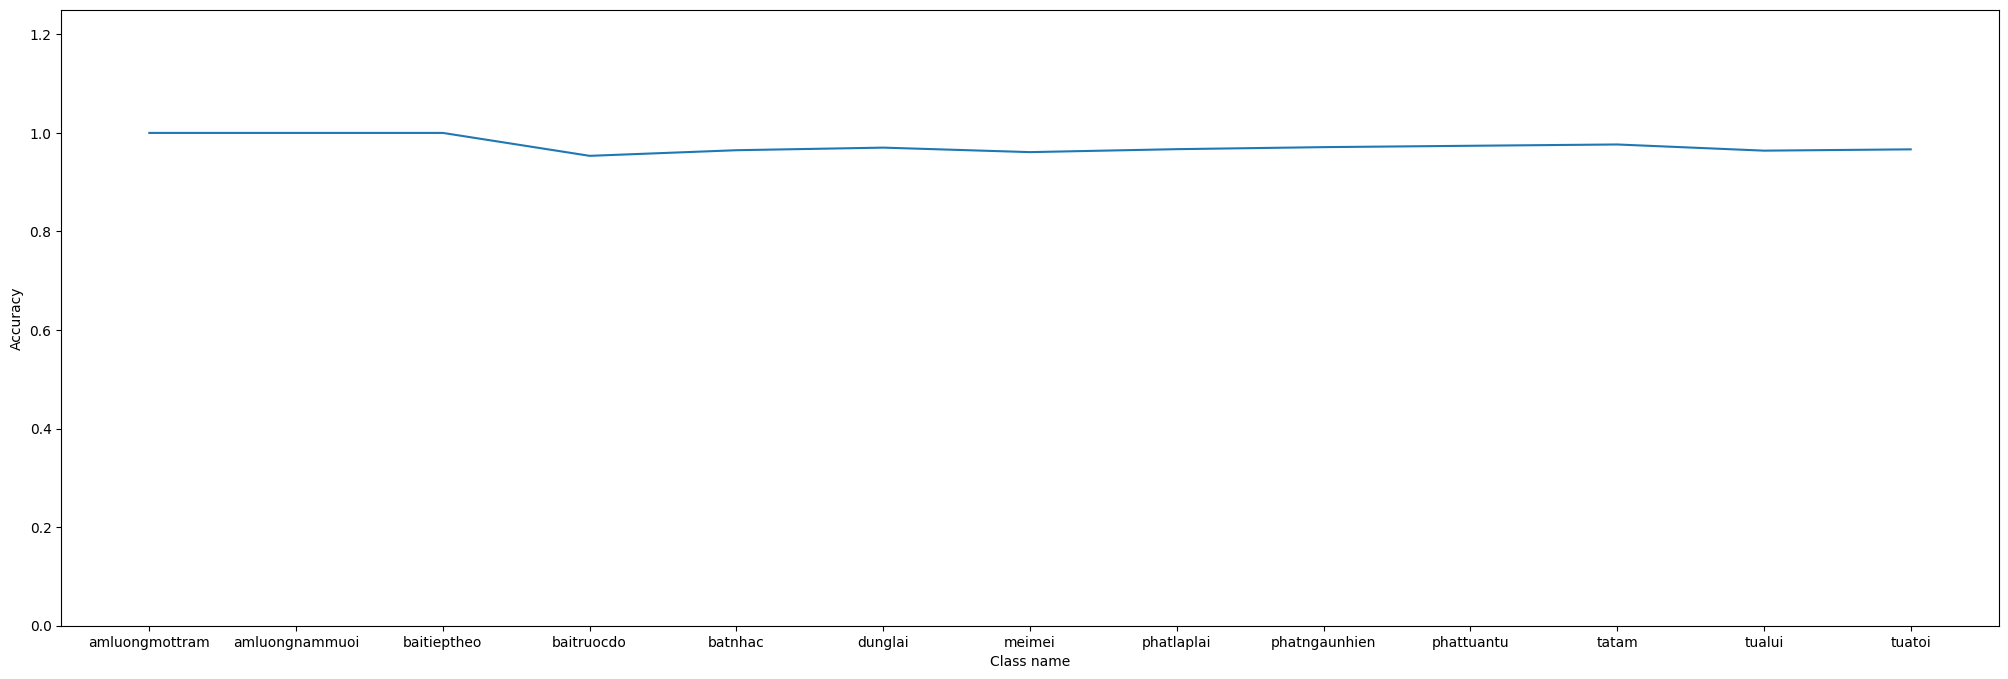

In [25]:
y_true = []
y_pred = []
accuracies = []
for cname in class_names:
    for mfcc, target in zip(X['test'][cname], y['test'][cname]):
        scores = [model[cname].score(mfcc) for cname in class_names]
        pred = np.argmax(scores)
        y_pred.append(pred)
        y_true.append(target)
    accuracy = (np.array(y_true) == np.array(y_pred)).sum() / len(y_true)
    accuracies.append(accuracy)
    print(f'{cname}:', accuracy)

plt.figure(figsize=(25,8))
plt.plot(class_names, accuracies)
plt.xlabel('Class name')
plt.ylabel('Accuracy')
plt.ylim([0, 1.25])
plt.show()


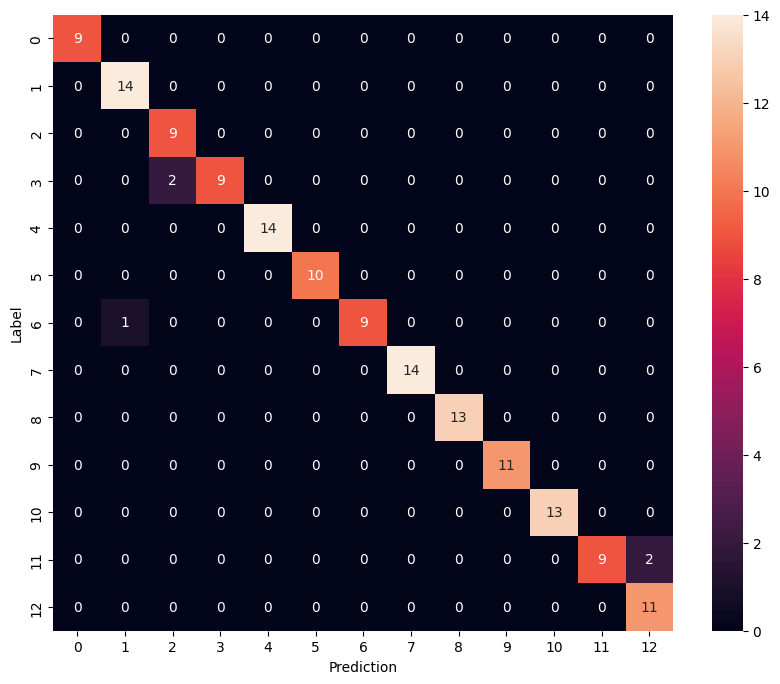

In [26]:
confusion_mtx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [27]:
report = classification_report( y_pred,y_true, target_names=class_names)
print(report)

                precision    recall  f1-score   support

amluongmottram       1.00      1.00      1.00         9
amluongnammuoi       1.00      0.93      0.97        15
   baitieptheo       1.00      0.82      0.90        11
    baitruocdo       0.82      1.00      0.90         9
       batnhac       1.00      1.00      1.00        14
       dunglai       1.00      1.00      1.00        10
        meimei       0.90      1.00      0.95         9
    phatlaplai       1.00      1.00      1.00        14
 phatngaunhien       1.00      1.00      1.00        13
    phattuantu       1.00      1.00      1.00        11
         tatam       1.00      1.00      1.00        13
        tualui       0.82      1.00      0.90         9
        tuatoi       1.00      0.85      0.92        13

      accuracy                           0.97       150
     macro avg       0.96      0.97      0.96       150
  weighted avg       0.97      0.97      0.97       150

